In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [113]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated")
df=data_df.loc[15:140,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation"]] 
print(df)

#start at 15 for churn
#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
15   Jan 11  57.677985        66.785907            28710.0  2.430000   
16   Feb 11  59.489130        70.022260            22565.0  1.990000   
17   Mar 11  69.479393        77.353399            19575.0  2.460000   
18   Apr 11  62.113734        79.431267            16590.0  2.680000   
19   May 11  62.462527        74.670881            19680.0  2.480000   
..      ...        ...              ...                ...       ...   
136  Feb 21  36.471127        40.980074            41235.0  1.897236   
137  Mar 21  42.778793        43.494060            44325.0  2.321223   
138  Apr 21  54.713896        42.188306            37515.0  2.111904   
139  May 21  54.765343        43.616761            35298.0  1.428956   
140  Jun 21  77.151842        47.484969            35409.0  1.016736   

      storage  temperature     euas     supply   coal_gbp   eurgbp    gbpusd  \
15   0.450000         5.10  17.7055  10.150000  81.9947

In [114]:
#Vector:
dprice_gas=df.price_gas
dprice_brent_gbp=df.price_brent_gbp
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn

time= df.months
DataSeries=[dtempdev, dstore, dlng, dprice_brent_gbp, dprice_gas]
#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [115]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-8.261315,0.000000,0.000000
storage,-2.882623,0.047406,11.000000
lng,-3.799564,0.002912,3.000000
price_brent_gbp,-1.852042,0.354947,2.000000
price_gas,-2.690770,0.075649,12.000000


In [116]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.310280,0.100000,3.000000
storage,0.224000,0.100000,5.000000
lng,0.348372,0.099409,5.000000
price_brent_gbp,1.174685,0.010000,6.000000
price_gas,0.934751,0.010000,6.000000


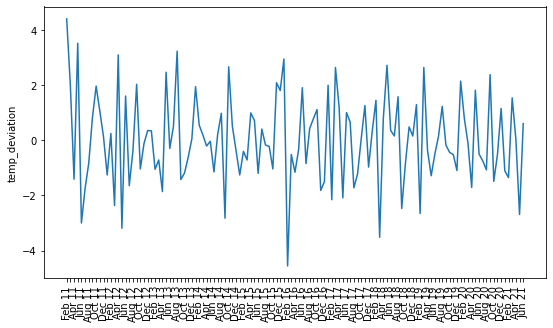

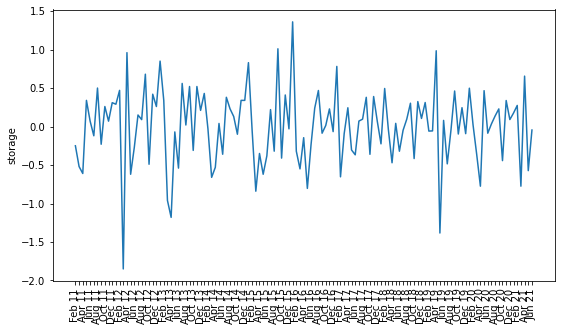

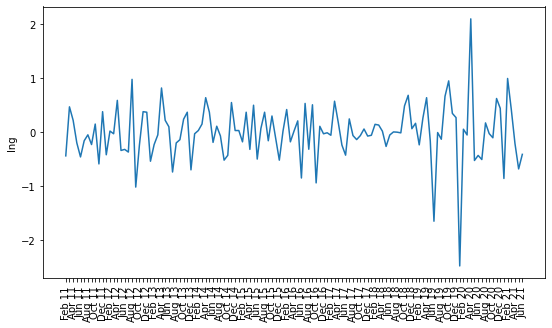

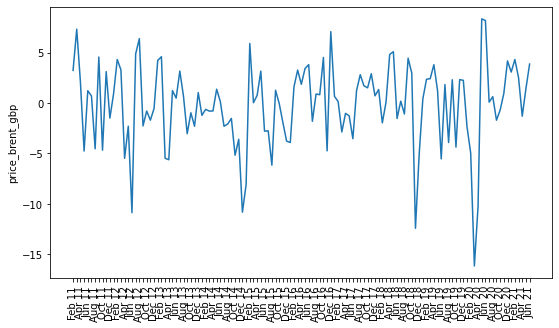

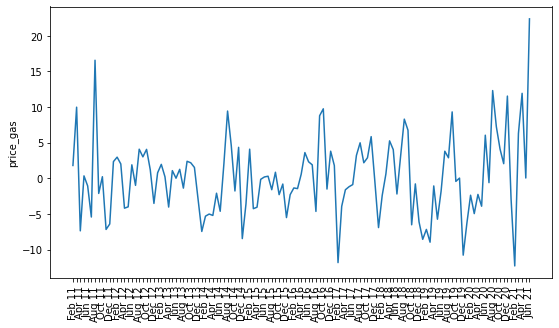

In [117]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'diff' # 'HP' for filtering or 'log' or 'bothHPlog'

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog':
            df_log = pd.Series(np.log(df))
            df = df_log

    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog':
        cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
        plt.plot(trend)
        plt.plot(cycle)
        cycle.name = df.name
        df = cycle

    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)




df_corr = pd.concat(DataSeriesCorr,axis=1)




In [118]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-8.612862,0.000000,5.000000
storage,-10.067417,0.000000,10.000000
lng,-7.195847,0.000000,5.000000
price_brent_gbp,-7.554619,0.000000,2.000000
price_gas,-4.846980,0.000044,4.000000


In [119]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.223778,0.100000,12.000000
storage,0.014712,0.100000,1.000000
lng,0.112549,0.100000,6.000000
price_brent_gbp,0.104762,0.100000,0.000000
price_gas,0.138528,0.100000,3.000000


In [120]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

     months  temp_deviation   storage       lng  price_brent_gbp  price_gas
16   Feb 11        4.398333 -0.250000 -0.440000         3.236354   1.811146
17   Mar 11        1.986667 -0.520000  0.470000         7.331138   9.990262
18   Apr 11       -1.408333 -0.610000  0.220000         2.077868  -7.365659
19   May 11        3.515000  0.340000 -0.200000        -4.760386   0.348793
20   Jun 11       -2.996667  0.070000 -0.460000         1.221877  -1.058454
..      ...             ...       ...       ...              ...        ...
136  Feb 21       -1.351667  0.274075  0.996634         4.318999 -12.290340
137  Mar 21        1.536667 -0.774803  0.423987         2.513986   6.307666
138  Apr 21        0.041667  0.655010 -0.209319        -1.305754  11.935103
139  May 21       -2.685000 -0.572943 -0.682949         1.428455   0.051447
140  Jun 21        0.603333 -0.045336 -0.412220         3.868208  22.386499

[125 rows x 6 columns]
     months  temp_deviation   storage       lng  price_brent_gbp

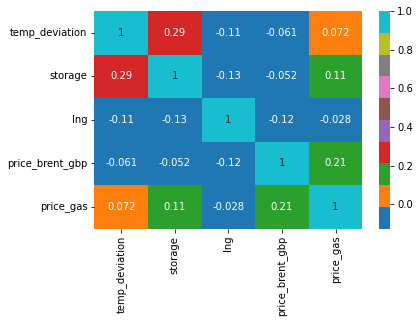

In [121]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


In [122]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


     months  temp_deviation   storage       lng  price_brent_gbp  price_gas
16   Feb 11        4.398333 -0.250000 -0.440000         3.236354   1.811146
17   Mar 11        1.986667 -0.520000  0.470000         7.331138   9.990262
18   Apr 11       -1.408333 -0.610000  0.220000         2.077868  -7.365659
19   May 11        3.515000  0.340000 -0.200000        -4.760386   0.348793
20   Jun 11       -2.996667  0.070000 -0.460000         1.221877  -1.058454
..      ...             ...       ...       ...              ...        ...
136  Feb 21       -1.351667  0.274075  0.996634         4.318999 -12.290340
137  Mar 21        1.536667 -0.774803  0.423987         2.513986   6.307666
138  Apr 21        0.041667  0.655010 -0.209319        -1.305754  11.935103
139  May 21       -2.685000 -0.572943 -0.682949         1.428455   0.051447
140  Jun 21        0.603333 -0.045336 -0.412220         3.868208  22.386499

[125 rows x 6 columns]


ValueError: could not convert string to float: 'Feb 11'

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


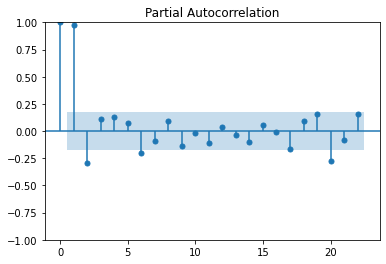

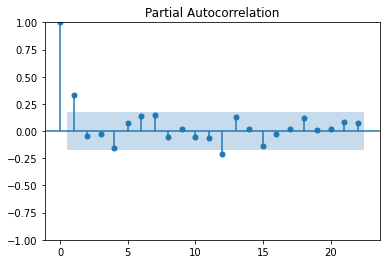

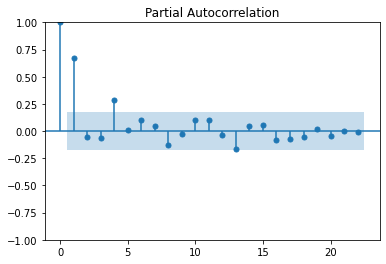

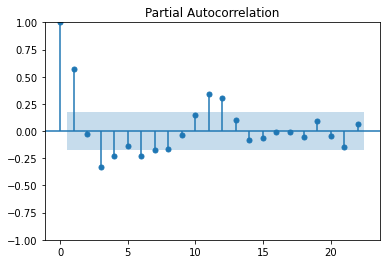

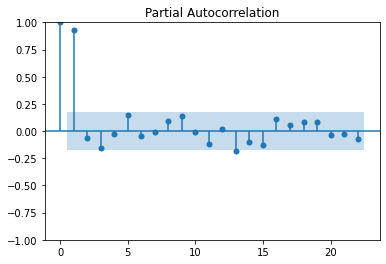

In [ ]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [ ]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,4.221,4.343*,68.12,4.271*
1,4.018,4.746,55.61,4.313
2,4.017,5.352,55.69,4.558
3,3.547,5.488,35.04*,4.334
4,3.645,6.193,39.13,4.679
5,3.668,6.823,40.90,4.948
6,3.814,7.576,48.80,5.340
7,3.995,8.364,61.12,5.767
8,3.977,8.953,63.74,5.996
9,3.904,9.487,64.20,6.169


In [ ]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Jul, 2022
Time:                     10:41:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    7.44010
Nobs:                     119.000    HQIC:                   5.29014
Log likelihood:          -916.572    FPE:                    48.5057
AIC:                      3.82023    Det(Omega_mle):         15.2430
--------------------------------------------------------------------
Results for equation price_brent_gbp
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.219163         0.364081           -0.602           0.547
L1.price_brent_gbp         0.210785         0.109789            1.920           0.055
L1.temp_deviation         -0.2

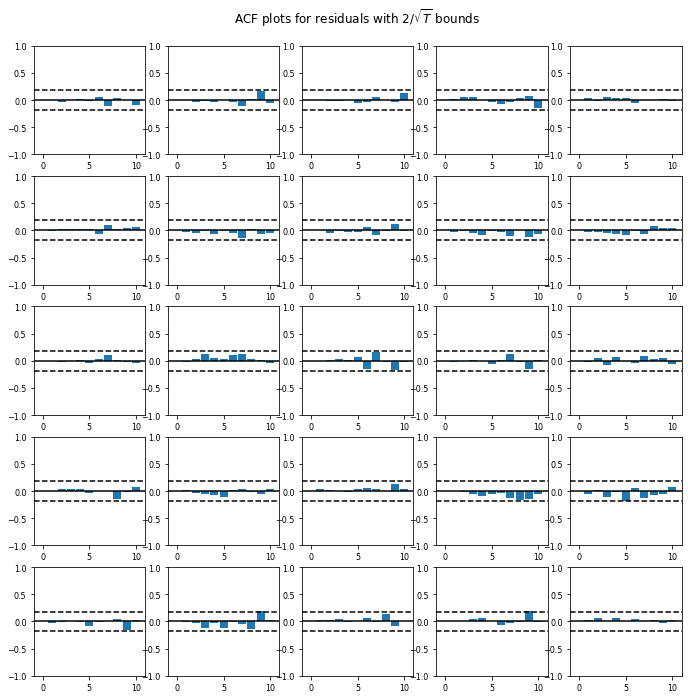

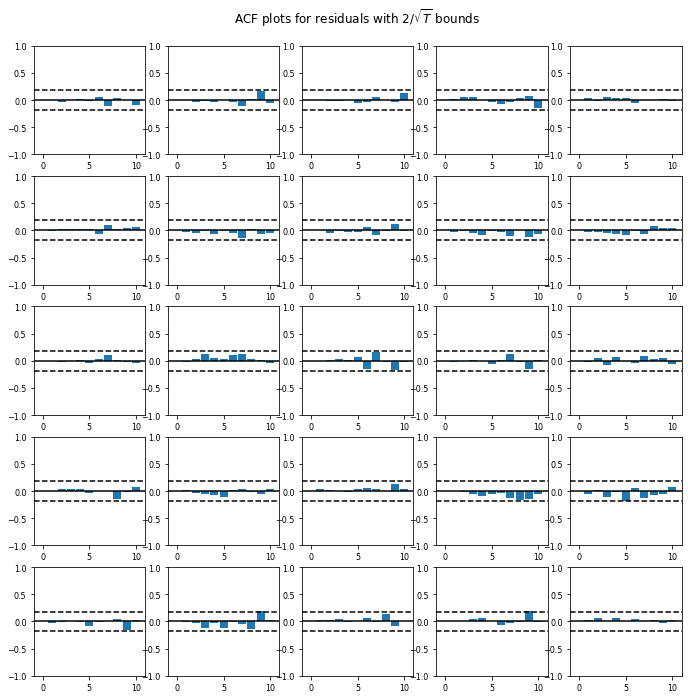

In [ ]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
model_fit.plot_acorr()

#if residuals out of range -> unstable model 

In [ ]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: lng does not Granger-cause price_gas. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.145          2.119   0.047 (6, 440)
----------------------------------------------


In [ ]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         53.76          18.31   0.000 10
----------------------------------------


In [ ]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         298.4          341.4   0.515 300
-----------------------------------------


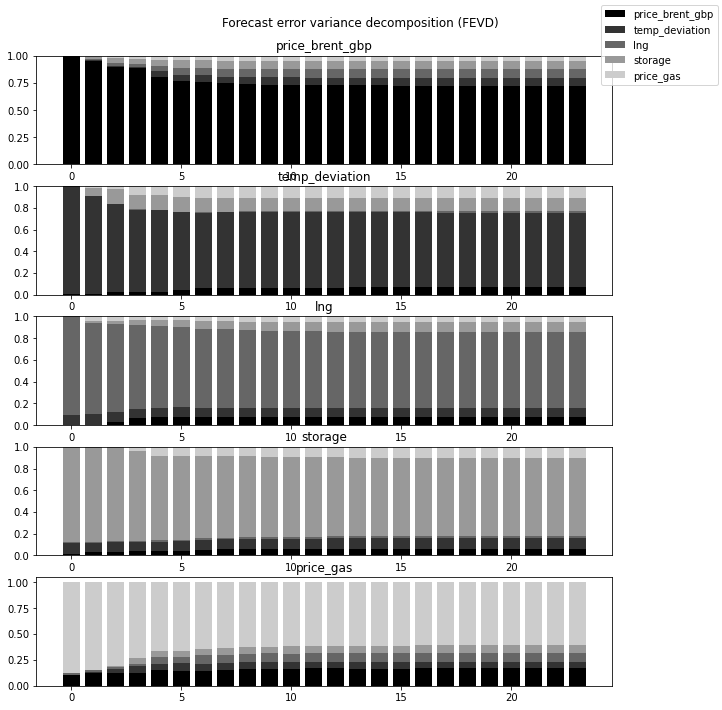

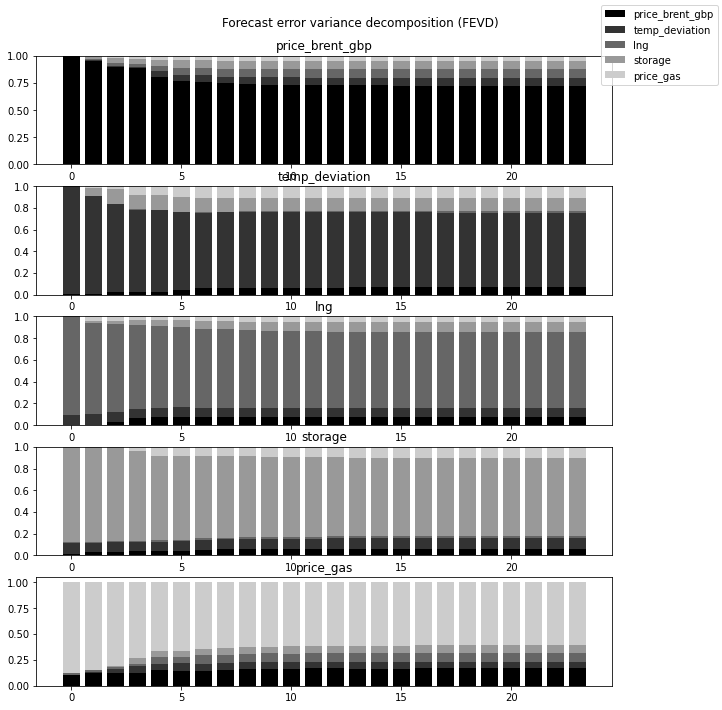

In [ ]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

IMPULSE RESPONSE ANALYSIS:

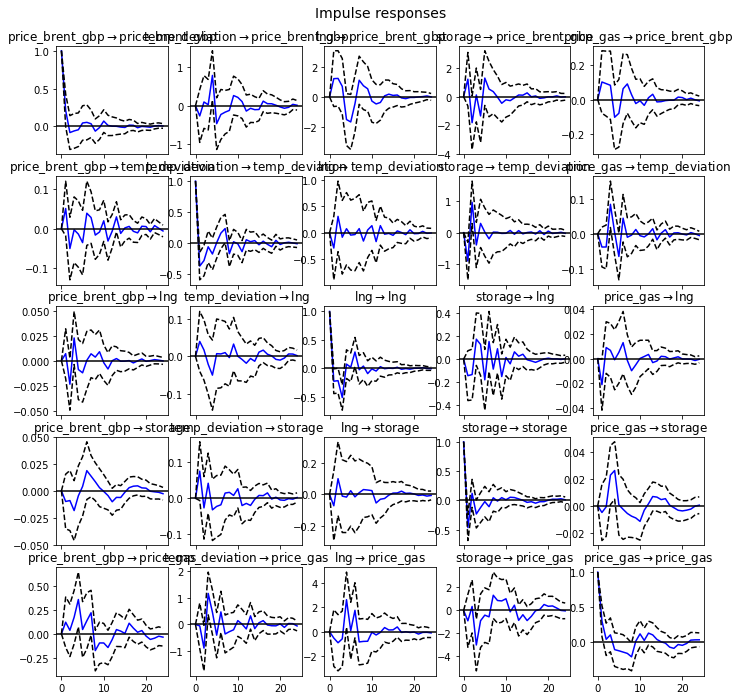

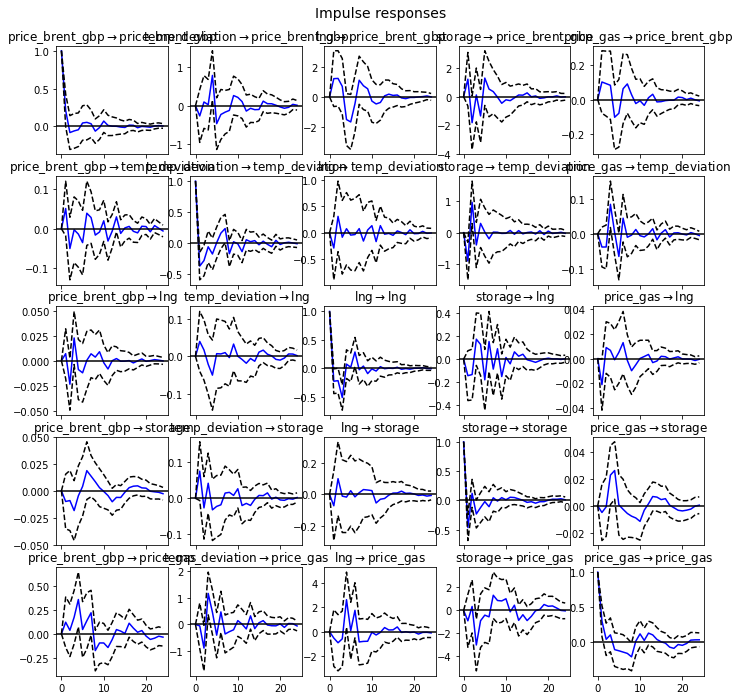

In [ ]:
irf = model_fit.irf(24)
irf.plot()

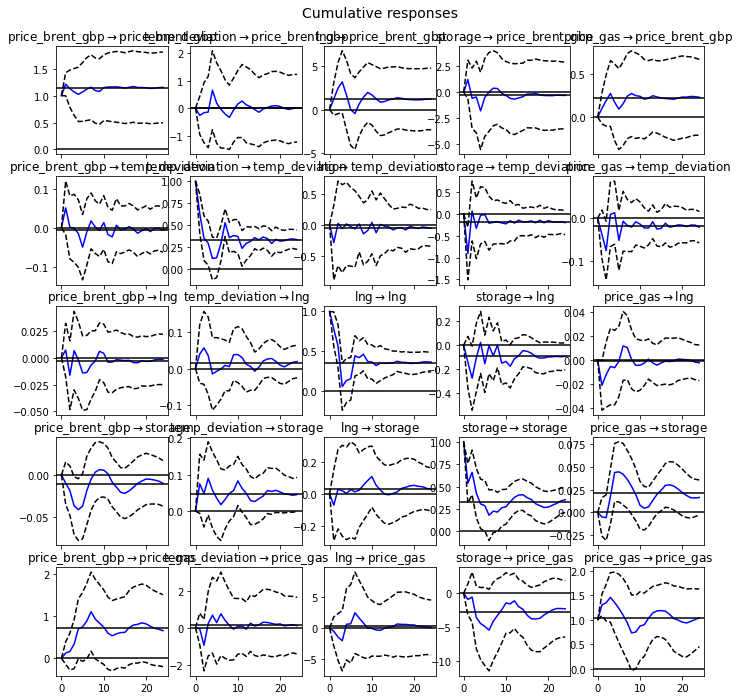

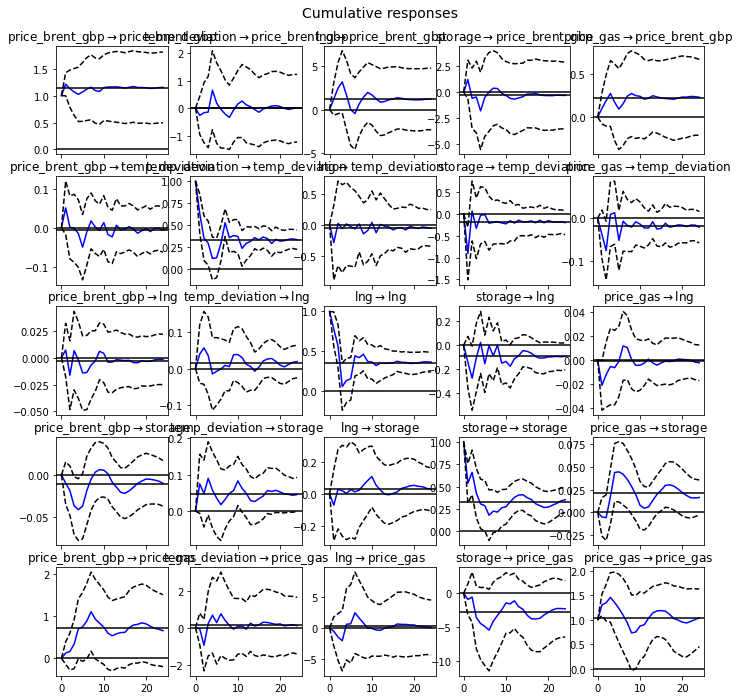

In [ ]:
irf.plot_cum_effects(orth=False)

OTHER MODELS

In [ ]:
from statsmodels.tsa.api import SVAR

lag_order =12

#A = np.asarray([[0, 0, 0],['E', 0, 0],[0, 'E', 0]])
#B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])

A = np.asarray([['E', 0],['E', 1]])
B = np.asarray([['E', 0], [0, 'E']])

StructModel = SVAR(df_corr,svar_type='AB',A=A, B=B)

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=10000, maxfun=10000, solver='bfgs')



ResSVAR.irf(periods=30).plot(impulse='churn', plot_stderr=True,stderr_type='mc', repl=100)

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


IndexError: index 4 is out of bounds for axis 0 with size 4